# Title

Importing relevant libraries

In [1]:
import numpy as num
import scipy as sci
import pandas as pd
import matplotlib.pyplot as plt
import nltk
import sklearn as skl
import xgboost
import gensim
import json
import re
import string
import seaborn as sns

In [2]:
trainingAmount = 10000
testAmount = 2500

df_train = pd.read_json('training' + str(trainingAmount) +'.json', lines=True)
df_test = pd.read_json('test' + str(testAmount) +'.json', lines=True)

df_test = df_test.drop("review_id", axis=1).drop("business_id", axis=1).drop("user_id", axis=1).drop("date", axis=1)
df_test = df_test.reindex(['text','stars','useful','funny','cool'], axis=1)

df_train = df_train.drop("review_id", axis=1).drop("business_id", axis=1).drop("user_id", axis=1).drop("date", axis=1)
df_train = df_train.reindex(['text','stars','useful','funny','cool'], axis=1)

## Defining the clean method

In [3]:
def clean(text):
    from nltk.stem import WordNetLemmatizer
    from nltk.stem.snowball import SnowballStemmer
    from nltk.tokenize import word_tokenize
    
     # Empty question
    if type(text) != str:
        return ''
    
    text = text.lower()
    
    # remove comma between numbers, i.e. 15,000 -> 15000
    text = re.sub('(?<=[0-9])\,(?=[0-9])', "", text)
    
    text = re.sub('[' + string.punctuation + ']', ' ', text)

    text = re.sub('im', "", text)

    
    
    #Tokenizing text for normalizing more easily
    tokenized_text = word_tokenize(text)
    
    
    
    #Removing stopwords
    stopwords = nltk.corpus.stopwords.words('english')
    kept_words = ['he', 'she', 'they', 'we']
    for kw in kept_words:
        stopwords.remove(kw)
    
    tokenized_text = [w for w in tokenized_text if not w in stopwords] 
    
    
#     #Removing numbers
#     tokenized_text = [w for w in tokenized_text if w.isalpha()]
    
    for token in tokenized_text:
        if not token.isalpha():
            token = '<Number>'
    
    
    
    #Putting tokens back together as a string
    text = ''
    for token in tokenized_text:
        text += token + ' '
        
    
    # Return a list of words
    return text

In [4]:
df_train['length'] = df_train['text'].apply(len)
df_test['length'] = df_test['text'].apply(len)

In [5]:
df_train.describe()

,stars,useful,funny,cool,length
count,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,3.716700,1.29820,0.458000,0.559000,581.699600
std,1.471549,2.90264,1.557973,2.056682,547.943392
min,1.000000,0.00000,0.000000,0.000000,2.000000
25%,3.000000,0.00000,0.000000,0.000000,231.000000
50%,4.000000,0.00000,0.000000,0.000000,414.000000
75%,5.000000,1.00000,0.000000,0.000000,737.000000
max,5.000000,91.00000,42.000000,86.000000,4998.000000


Cleaning the data

In [6]:
df_train['cleaned_text'] = df_train['text'].apply(clean)
df_test['cleaned_text'] = df_test['text'].apply(clean)

Saving all the necessary data in arrays

In [7]:
df_test

,text,stars,useful,funny,cool,length,cleaned_text
0,WOW!! This company is amazing!!!!! As a full t...,5,0,0,0,564,wow company amazing full te working mom tell h...
1,We had an appointment for 6:50 and we are stil...,1,0,0,0,152,we appointment 6 50 we still waiting 30 minute...
2,Review is purely on the food because this is j...,4,0,0,0,634,review purely food standard quick casino fare ...
3,"First of all, the inside is super clean and or...",5,1,0,0,388,first inside super clean organized they beauti...
4,I had seen this place featured on some Charlot...,5,1,0,1,1476,seen place featured charlotte afternoon talk s...
5,I stopped because it was very early (before 8a...,1,2,0,1,625,stopped early 8am need pickup three things exp...
6,I had a meeting for an estimate on June 1. Chr...,1,21,0,0,252,meeting estate june 1 chris came give estate k...
7,"A fantastic place to train, especially if you ...",5,0,0,0,241,fantastic place train especially want serious ...
8,I come here frequently for an upper lip wax. T...,4,2,1,2,204,come frequently upper lip wax they always able...
9,I have been going to this nail salon for years...,2,4,0,0,1247,going nail salon years close home used get gre...


In [8]:
train = df_train['cleaned_text'].values
test = df_test['cleaned_text'].values
trainStars = df_train['stars'].values
testStars = df_test['stars'].values

## BOW model with Naïve Bayes Classifier

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB

vectorizer = CountVectorizer()
trainVecs = vectorizer.fit_transform(train)
testVecs = vectorizer.transform(test)

In [ ]:
from sklearn.naive_bayes import MultinomialNB
classifierNB = MultinomialNB()
classifierNB.fit(trainVecs, trainStars)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [ ]:
testStars_predicted = classifierNB.predict(testVecs)
print(classifierNB.score(testVecs, testStars)*100, "%")

59.56 %


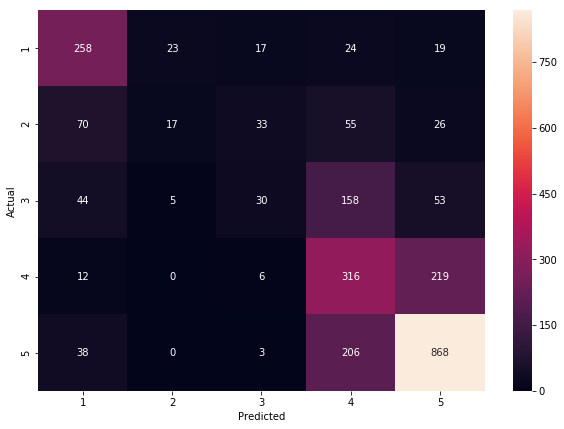

In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(testStars, testStars_predicted, labels=None, sample_weight=None)

df_cm = pd.DataFrame(confusion_matrix, index = [i for i in "12345"],
                  columns = [i for i in "12345"])
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True, fmt='g')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

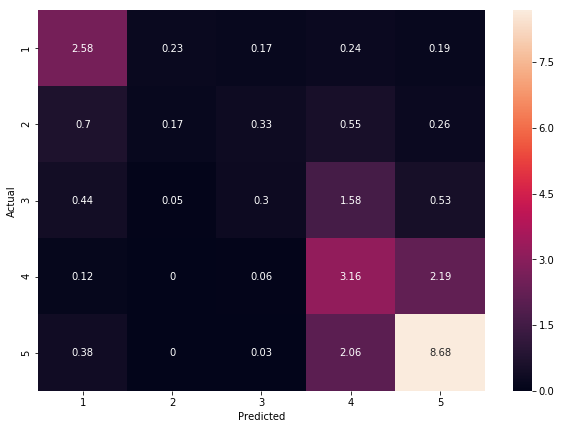

In [ ]:
confusion_matrix_percentage = confusion_matrix / df_train.shape[0] * 100

df_cm = pd.DataFrame(confusion_matrix_percentage, index = [i for i in "12345"],
                  columns = [i for i in "12345"])
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True, fmt='g')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

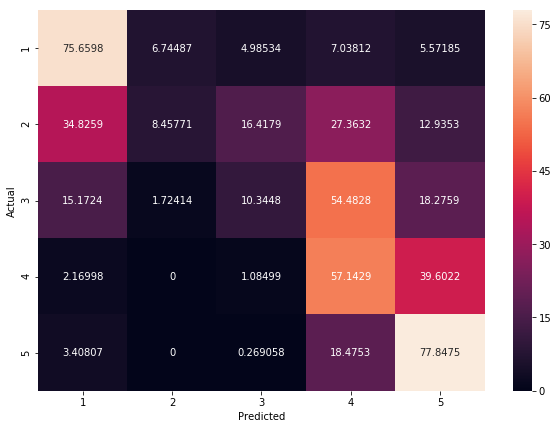

In [ ]:
confusion_matrix_proportions = []
for n in range(confusion_matrix.shape[0]):
    confusion_matrix_proportions.append(confusion_matrix[n,:]/df_test.groupby('stars').count().at[n+1, 'text']*100)
    
confusion_matrix_proportions = num.array(confusion_matrix_proportions)

df_cm = pd.DataFrame(confusion_matrix_proportions, index = [i for i in "12345"],
                  columns = [i for i in "12345"])
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True, fmt='g')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [ ]:
import collections
distance = num.abs(testStars - testStars_predicted)
collections.Counter(distance)

Counter({0: 1489, 4: 57, 1: 720, 2: 172, 3: 62})

## Word2Vec model

In [ ]:
from nltk.tokenize import word_tokenize
from gensim.models import Word2Vec

train_tokenized = [word_tokenize(token) for token in train]
test_tokenized = [word_tokenize(token) for token in test]

word2vec = Word2Vec(train_tokenized, min_count=10)

word2vec.init_sims(replace=True)

In [ ]:
def sent2vec(reviewTok):
    vecSize = len(word2vec.wv[reviewTok[0][0]])
    reviewVec = []
    for sentence in reviewTok:
        vectorSum = num.zeros(vecSize)
        empty = True
        for token in sentence:
            if token in word2vec.wv.vocab:
                vectorSum += word2vec.wv[token]
                empty = False
        if not empty:
            vectorSum = vectorSum / num.sqrt((vectorSum ** 2).sum())
        reviewVec.append(vectorSum)
    return num.array(reviewVec)

In [ ]:
train_vectors = sent2vec(train_tokenized)
test_vectors = sent2vec(test_tokenized)

In [ ]:
from xgboost import XGBClassifier
xgbclassifier = XGBClassifier()
xgbclassifier.fit(train_vectors, trainStars)

In [ ]:
print(xgbclassifier.score(test_vectors, testStars)*100, '%')

***

### Looking for relation between text length and rating
Tests with charts

In [ ]:
g = sns.FacetGrid(data=df_test, col='stars')
g.map(plt.hist, 'length', bins=50)

In [ ]:
sns.boxplot(x='stars', y='length', data=df_test)

In [ ]:
df_test.describe()

In [ ]:
starProp_train = df_train.groupby('stars').count().drop('useful', axis=1).drop('funny', axis=1).drop('cool', axis=1).drop('length', axis=1)
starProp_train['percentage'] = starProp_train['cleaned_text'] / df_train.shape[0] * 100
starProp_train


In [ ]:
starProp_test = df_test.groupby('stars').count().drop('useful', axis=1).drop('funny', axis=1).drop('cool', axis=1).drop('length', axis=1)
starProp_test['percentage'] = starProp_test['cleaned_text'] / df_test.shape[0] * 100
starProp_test


Training and test set have same proportions! :-)

ideas:
- make a numbers token <NUMBER>
- stem the words
- remove stopwords
- create a personal noun token <PERSONALNOUN>

In [ ]:
stopwords = nltk.corpus.stopwords.words('english')
print(stopwords)